In [1]:
import matplotlib as mpl
#matplotlib.use('Agg')

In [2]:
import os
import datetime
import time
import copy
import shutil
import sys
sys.path.append('/cnrm/pastel/USERS/lecestres/analyse/')
from function_read import *
from HW_detection import *
from forecast_veri import *
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import calendar
import locale
locale.setlocale( locale.LC_ALL , 'en_US' )
from netCDF4 import num2date, date2num 
import netCDF4
from math import sin, cos, sqrt, atan2, radians
from sklearn.neighbors import DistanceMetric
from math import radians

from joblib import Parallel, delayed
import joblib

In [3]:
from scipy.stats import pearsonr, spearmanr

In [4]:
### EXPERIENCE NAME
expname_ref = "ocean_reanalysis_GREP"
expname_tocompare = "sst_retroprevision_sys7"

### PERCENTILE THRESHOLD
percent_thresh = 95
#percent_thresh = 90

### MINIMAL DURATION OF A HW
duration_min = 5
#duration_min = 3

### REGION OF EXPERIENCE

#reg_name = 'north_pacific'
#reg_name = 'north_atlantic'
#reg_name = 'indian_ocean'
#reg_name = 'austral_ocean'
#reg_name = 'tropical_atlantic'
#reg_name = 'tropical_pacific'
#reg_name = 'mediterranee'
reg_name = 'global'

if reg_name == 'north_pacific':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([120, -120])
    central_lon = 180
    cross_greenwich = False
    cross_antimeridian = True
    reg_name2 = 'Pacific North ocean'
    
if reg_name == 'north_atlantic':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([-80, 0])
    central_lon = 320
    cross_greenwich = False
    cross_antimeridian = False
    reg_name2 = 'Atlantic North ocean'
    
if reg_name == 'indian_ocean':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([45, 110])
    central_lon = 77.5
    cross_greenwich = False
    cross_antimeridian = False
    reg_name2 = 'Indian ocean'
    
if reg_name == 'austral_ocean':
    lats_bnds = np.array([-90,-30])
    lons_bnds = np.array([-180, 180])
    central_lon = 0
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Austral ocean'
    
if reg_name == 'tropical_atlantic':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([-70, 20])
    central_lon = 335
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Atlantic Tropical ocean'
    
if reg_name == 'tropical_pacific':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([120, -70])
    central_lon = -155
    cross_greenwich = False
    cross_antimeridian = True
    reg_name2 = 'Pacific Tropical ocean'
    
if reg_name == 'mediterranee':
    lats_bnds = np.array([30,50])
    lons_bnds = np.array([-5, 40])
    central_lon = 17.5
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Mediterranean sea'
    
if reg_name == 'global':
    lats_bnds = np.array([-90,90])
    lons_bnds = np.array([-180,180])
    central_lon = 0
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Earth'
    
nlat = lats_bnds[1]-lats_bnds[0]
if lons_bnds[1]<lons_bnds[0]:
    nlon = lons_bnds[1]%360-lons_bnds[0]
else:
    nlon = lons_bnds[1]-lons_bnds[0]

### YEARS
if expname_ref == 'ocean_reanalysis_GREP':
    end_year_ref=2016
    start_year_ref=1993
if expname_tocompare == 'sst_retroprevision_sys7':
    end_year_tocompare=2016
    start_year_tocompare=1993

nyear=end_year_tocompare-start_year_tocompare+1

### SEASON
#season = "NDJFMAM"
season = "DJF"
if season == 'NDJFMAM':
    nday = 211
    season_start_day = [11,1] #1stNov
    season_end_day = [5,31] #31stMay
    dayzero = 0
elif season == 'DJF':
    nday = 90
    season_start_day = [12,1] #1stDec
    season_end_day = [3,1] #1stMarch
    first_day = 30
ndayseas = nday//duration_min +1


if expname_ref == "ocean_reanalysis_GREP":    
    ### NUMBER OF MEMBS
    memb_ref=0
    nmemb_ref = 1
    memb_str_ref='memb'+str(memb_ref)
    
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str_ref = "CV"
    else:
        cv_str_ref = 'notCV'
        
if expname_tocompare == "sst_retroprevision_sys7":    
    ### NUMBER OF MEMBS
    memb_start_tocompare=0
    memb_end_tocompare=25
    nmemb_tocompare = memb_end_tocompare-memb_start_tocompare
    membs_str_lst_tocompare=['memb'+str(imemb) for imemb in range(nmemb_tocompare)]
           
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str_tocompare = "CV"
    else:
        cv_str_tocompare = 'notCV'
    
    

### PARAMETERS
parameters_str_ref = reg_name + "_" + season + "_" + cv_str_ref + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "_ref%i-%i"%(start_year_ref, end_year_ref)+'_'+memb_str_ref
# parameters_str_tocompare = reg_name + "_" + season + "_" + cv_str_tocompare + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "_ref%i-%i"%(start_year_tocompare, end_year_tocompare)
# parameters_tocompare defined later because they dpend on each memb

# HWMI, N95, SST_mean correlation

In [5]:
### NAME OF THE VARIABLES IN THE NC FILES
varname_ref = 'HWMI_' + parameters_str_ref
varname2_ref = 'nbdaygtpercentpct'
varname3_ref = 'sst_mean'

In [6]:
pathHWMI_ref = '/cnrm/pastel/USERS/lecestres/NO_SAVE/data/'+expname_ref+'/'+memb_str_ref+'/'+season+'/'+varname_ref+'/'
files_ref = glob(pathHWMI_ref + '*.nc')
files_ref.sort()

In [7]:
HWMI_ref = np.ma.zeros((nyear,nlat,nlon))
Nthresh_ref = np.ma.zeros((nyear, nlat, nlon))
SSTmean_ref = np.ma.zeros((nyear,nlat,nlon))
for iyear, file_ref in enumerate(files_ref[:]):
    varf_ref=netCDF4.Dataset(file_ref)
    vararray_ref, lats_reg_ref, lons_reg_ref = extract_array(varf_ref, varname_ref, ndayseas, np.array(lons_bnds), np.array(lats_bnds),  start_time = 0, level=0)
    HWMI_ref[iyear,:,:] = vararray_ref[0,:,:]
    
    vararray_ref2, lats_reg_ref, lons_reg_ref = extract_array(varf_ref, varname2_ref, ndayseas, np.array(lons_bnds), np.array(lats_bnds),  start_time = 0, level=0)
    Nthresh_ref[iyear,:,:] = vararray_ref2[0,:,:]
    
    vararray_ref3, lats_reg_ref, lons_reg_ref = extract_array(varf_ref, varname3_ref, ndayseas, np.array(lons_bnds), np.array(lats_bnds),  start_time = 0, level=0)
    SSTmean_ref[iyear,:,:] = vararray_ref3[0,:,:]
    varf_ref.close()

In [8]:
files_tocompare_all = []
for imemb_str in membs_str_lst_tocompare:
    parameters_str_tocompare_imemb = reg_name+"_"+season+"_"+cv_str_tocompare+'_percent%i'%(percent_thresh)+'_daymin%i'%(duration_min)+"_ref%i-%i"%(start_year_tocompare, end_year_tocompare)+'_'+imemb_str
    varname_tocompare = 'HWMI_' + parameters_str_tocompare_imemb
    pathHWMI_tocompare = '/cnrm/pastel/USERS/lecestres/NO_SAVE/data/'+expname_tocompare+'/'+imemb_str+'/'+season+'/'+varname_tocompare+'/'
    files_tocompare = glob(pathHWMI_tocompare + '*.nc')
    files_tocompare.sort()
    files_tocompare_all.append(files_tocompare)

In [9]:
HWMImembs_tocompare = np.ma.zeros((nmemb_tocompare, nyear, nlat, nlon))
Nthreshmembs_tocompare = np.ma.zeros((nmemb_tocompare, nyear, nlat, nlon))
SSTmeanmembs_tocompare = np.ma.zeros((nmemb_tocompare, nyear, nlat, nlon))
for imemb, files in enumerate(files_tocompare_all):
    if files != []:
        memb_str = 'memb' + str(imemb)
        ### PARAMETERS
        parameters_str = reg_name + "_" + season + "_" + cv_str_tocompare + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "_ref%i-%i"%(start_year_tocompare, end_year_tocompare) + '_' + memb_str
        varname_tocompare = 'HWMI_' + parameters_str
        varname2_tocompare = 'nbdaygtpercentpct'
        varname3_tocompare = 'sst_mean'
        for iyear,file in enumerate(files):
            varf = netCDF4.Dataset(file)
            vararray = varf.variables[varname_tocompare][:]
            lats_reg, lons_reg = varf.variables['lat'][:], varf.variables['lon'][:]
            HWMImembs_tocompare[imemb,iyear,:,:] = vararray[0,:,:]
            vararray2 = varf.variables[varname2_tocompare][:]
            Nthreshmembs_tocompare[imemb,iyear,:,:] = vararray2[0,:,:]
            vararray3 = varf.variables[varname3_tocompare][:]
            SSTmeanmembs_tocompare[imemb,iyear,:,:]=vararray3[0,:,:]
            
            del vararray
            del vararray2
            del vararray3
            varf.close()

In [10]:
HWMI_tocompare = np.ma.mean(HWMImembs_tocompare, axis=0)
Nthresh_tocompare = np.ma.mean(Nthreshmembs_tocompare, axis=0)
SSTmean_tocompare = np.ma.mean(SSTmeanmembs_tocompare, axis=0)

In [11]:
# Union between the reference mask area and the one to compare
maskunion = np.zeros((nlat,nlon))
for i in range(nlat):
    for j in range(nlon):
        trueref = HWMI_ref.mask[0,i,j]
        truetocomp = HWMI_tocompare.mask[0,i,j]
        maskunion[i,j] = trueref or truetocomp

for i in range(nyear):
    HWMI_ref.mask[i,:,:] = maskunion
    HWMI_tocompare.mask[i,:,:] = maskunion
    Nthresh_tocompare.mask[i,:,:] = maskunion
    Nthresh_ref.mask[i,:,:] = maskunion
    SSTmean_tocompare.mask[i,:,:]=maskunion
    SSTmean_ref.mask[i,:,:]=maskunion

In [12]:
HWMI_anom_ref = comp_anom_cv(HWMI_ref, 0, posens=-1)
HWMI_anom_tocompare = comp_anom_cv(HWMI_tocompare,0, posens=-1)

Nthresh_anom_ref = comp_anom_cv(Nthresh_ref, 0, posens=-1)
Nthresh_anom_tocompare = comp_anom_cv(Nthresh_tocompare,0, posens=-1)

SSTmean_anom_ref = comp_anom_cv(SSTmean_ref, 0, posens=-1)
SSTmean_anom_tocompare = comp_anom_cv(SSTmean_tocompare, 0, posens=-1)

HWMI_corr_pearson = np.ma.zeros((nlat,nlon))
HWMI_corr_pearson.mask = maskunion
HWMI_p_pearson = np.ma.zeros((nlat, nlon))
HWMI_p_pearson.mask = maskunion
Nthresh_corr_pearson = np.ma.zeros((nlat,nlon))
Nthresh_corr_pearson.mask = maskunion
Nthresh_p_pearson = np.ma.zeros((nlat,nlon))
Nthresh_p_pearson.mask = maskunion
SSTmean_corr_pearson = np.ma.zeros((nlat,nlon))
SSTmean_corr_pearson.mask = maskunion
SSTmean_p_pearson = np.ma.zeros((nlat,nlon))
SSTmean_p_pearson.mask = maskunion

for i in range(nlat):
    for j in range(nlon):
        if not(maskunion[i,j]):
            HWMI_corr_pearson[i,j], HWMI_p_pearson[i,j] = pearsonr(HWMI_anom_ref[:,i,j], HWMI_anom_tocompare[:,i,j])
            Nthresh_corr_pearson[i,j], Nthresh_p_pearson[i,j] = pearsonr(Nthresh_anom_ref[:,i,j], Nthresh_anom_tocompare[:,i,j])
            SSTmean_corr_pearson[i,j], SSTmean_p_pearson[i,j] = pearsonr(SSTmean_anom_ref[:,i,j], SSTmean_anom_tocompare[:,i,j])
        else:
            HWMI_corr_pearson.mask[i,j]=True
            Nthresh_corr_pearson.mask[i,j]=True
            SSTmean_corr_pearson.mask[i,j]=True

/usr/lib64/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


### HWMI, N95, SST_mean Corelation for stat model

In [14]:
from scipy.stats import linregress

def predtrend(y):
    nyear, nlat, nlon = y.shape
    x=np.arange(nyear)
    modtrend = np.zeros((nyear, nlat, nlon))
    cortrend = np.zeros((nlat, nlon, 2))
    for ilon in range(nlon):
        for ilat in range(nlat):
            for iyear in range(nyear):
                xcv=np.delete(x, iyear)
                ycv=np.delete(y[:,ilat, ilon], iyear)
                #print(xcv.shape, ycv.shape)
                linreg = linregress(xcv, ycv)
                modtrend[iyear, ilat, ilon] = x[iyear]*linreg.slope+linreg.intercept
            cortrend[ilat,ilon,:]=pearsonr(y[:, ilat, ilon], modtrend[:, ilat, ilon])
    return(modtrend, cortrend)

HWMImodtrendvar1, HWMIcortrend1 = predtrend(HWMI_anom_ref)
Nthreshmodtrendvar1, Nthreshcortrend1 = predtrend(Nthresh_anom_ref)
SSTmeanmodtrandvar1, SSTmeancortrend1 = predtrend(SSTmean_anom_ref)

doublemaskunion=np.concatenate((maskunion[:,:,np.newaxis],maskunion[:,:,np.newaxis]), axis=2)
HWMIcortrend1 = np.ma.array(HWMIcortrend1, mask = doublemaskunion)
Nthreshcortrend1 = np.ma.array(Nthreshcortrend1, mask= doublemaskunion)
SSTmeancortrend1 = np.ma.array(SSTmeancortrend1, mask=doublemaskunion)

In [19]:
cmap = mpl.cm.RdBu_r
bounds = np.linspace(-1,1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def plotfield(ax, lon, lat, field, title): #, title, bounds, cmin, cmax, cmap, norm, cbar=True, signi=False, signicor=False, extend="neither"):
    #ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    if cross_greenwich:
        lon[lon>180]=lon[lon>180]-360
    elif cross_antimeridian:
        #lat[lat>180]=lat[lat>180]-360
        lon[lon<0]=lon[lon<0]+360
    lon2d, lat2d = np.meshgrid(lon, lat)
    ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    plot = ax.contourf(lon2d, lat2d, field, bounds, transform=ccrs.PlateCarree(), cmap = cmap, norm=norm)
    fig.colorbar(plot, orientation = 'horizontal', ax=ax, shrink=0.7, spacing='proportional')
    ax.set_title(title, fontsize=13, fontweight='demibold')
    
def plotsignif(ax,lon,lat, HWMI_anom_P):
    if cross_greenwich:
        lon[lon>180]=lon[lon>180]-360
    elif cross_antimeridian:
        #lat[lat>180]=lat[lat>180]-360
        lon[lon<0]=lon[lon<0]+360
    ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], ccrs.PlateCarree())
    lon2d, lat2d = np.meshgrid(lon, lat)
    print(ax.set_xlim())
    print(lon2d[HWMI_anom_P<0.05])
    ax.plot(lon2d[HWMI_anom_P<0.05]-lons_bnds[0]+ax.set_xlim()[0], lat2d[HWMI_anom_P<0.05], color='black', marker="o", markersize=0.5) 

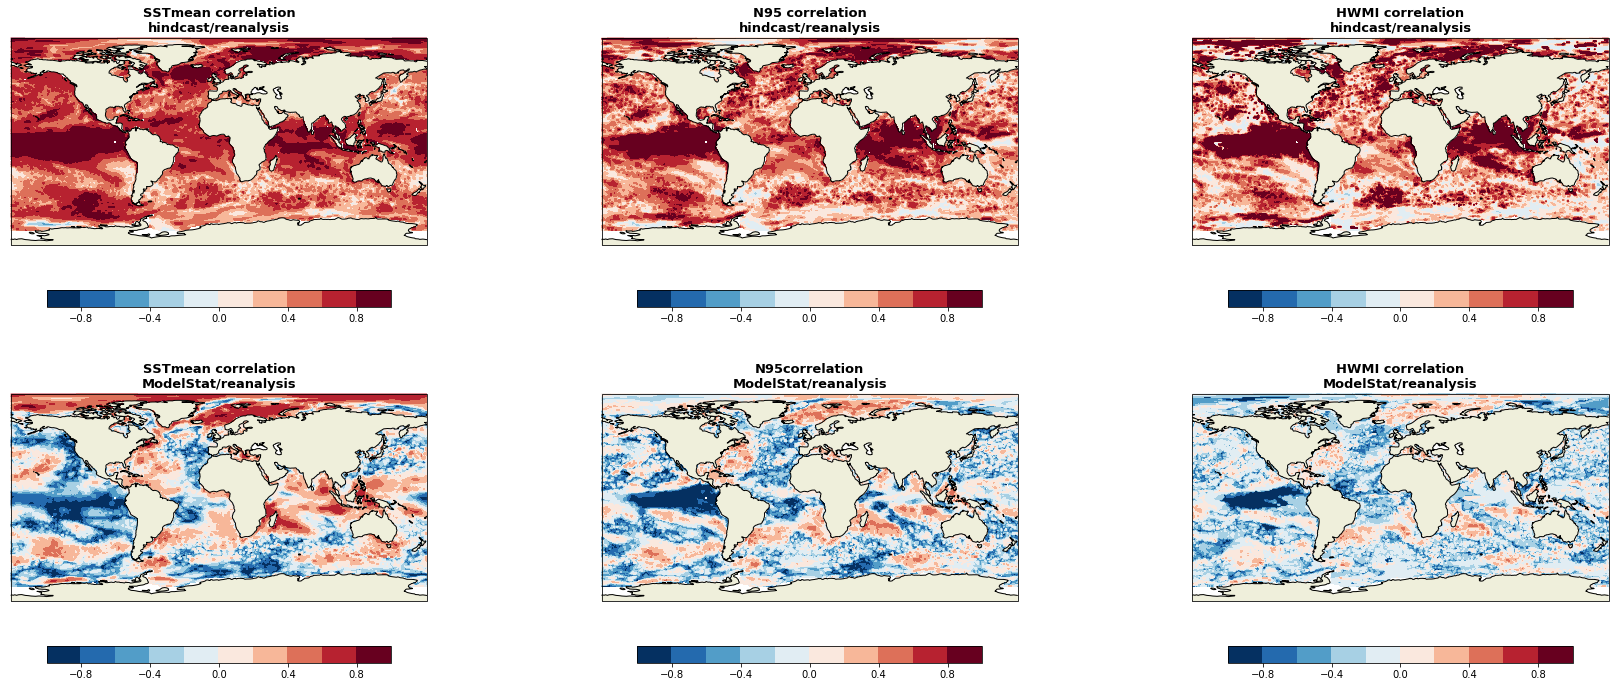

In [31]:
export_path='Propres_Indexes_correlations_'+reg_name
ncol = 3
nline = 2
gridict = {'wspace' : 0.2, 'hspace' : 0.2}

fig, axs = plt.subplots(ncols=ncol, nrows=nline, gridspec_kw=gridict, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=central_lon)}, figsize=(30,12))
#fig.suptitle('HWMI, N95 and SSTmean spatial correlations in '+reg_name, fontsize = 20, family='sans-serif',fontweight='demibold')
plotfield(axs[0,2], lons_reg, lats_reg, HWMI_corr_pearson, 'HWMI correlation\nhindcast/reanalysis')
#plotsignif(axs[0,0], lons_reg, lats_reg, HWMI_p_pearson)

plotfield(axs[1,2], lons_reg, lats_reg, HWMIcortrend1[:,:,0], 'HWMI correlation\nModelStat/reanalysis')
#plotsignif(axs[1,0], lons_reg, lats_reg, HWMIcortrend1[:,:,1])

Nthresh_str = 'N'+str(percent_thresh)
plotfield(axs[0,1], lons_reg, lats_reg, Nthresh_corr_pearson, Nthresh_str + ' correlation\nhindcast/reanalysis')
#plotsignif(axs[0,1], lons_reg, lats_reg, Nthresh_p_pearson)

plotfield(axs[1,1], lons_reg, lats_reg, Nthreshcortrend1[:,:,0], Nthresh_str + 'correlation\nModelStat/reanalysis')
#plotsignif(axs[1,1], lons_reg, lats_reg, Nthreshcortrend1[:,:,1])

plotfield(axs[0,0], lons_reg, lats_reg, SSTmean_corr_pearson, 'SSTmean correlation\nhindcast/reanalysis')
#plotsignif(axs[0,2], lons_reg, lats_reg, SSTmean_p_pearson)

plotfield(axs[1,0], lons_reg, lats_reg, SSTmeancortrend1[:,:,0], 'SSTmean correlation\nModelStat/reanalysis')
#plotsignif(axs[1,2], lons_reg, lats_reg, SSTmeancortrend1[:,:,1])
plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/HWMIS/'+export_path+'.pdf')

In [25]:
HWMI_corr_pearson.data[np.isnan(HWMI_corr_pearson.data)] = 1

In [27]:
HWMIcortrend1[:,:,0].data[np.isnan(HWMIcortrend1[:,:,0].data)] = -0.85